### PAR-2 RING SEC-MALS (Part 1)

Context:
- SEC-MALS traces for PAR-2 RING at a range of input concentrations
- Additionally a single data point for L109R (we were unable to purify enough for higher concentrations)

Results:
- Clear evidence for concentration-dependent dimerisation
- L109R appears mainly monomeric

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
sys.path.append('../../..')
from src import raw_data_path
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

if not os.path.exists('Figs'):
    os.mkdir('Figs')

### Import data

In [2]:
csv_wt_500ugml = pd.read_csv(raw_data_path + 'SEC MALS/csv/20220128_Par2Ring_WT_S75_500ugml.csv')
csv_wt_750ugml = pd.read_csv(raw_data_path + 'SEC MALS/csv/20220128_Par2Ring_WT_S75_750ugml.csv')
csv_wt_2000ugml = pd.read_csv(raw_data_path + 'SEC MALS/csv/20210927_Par2Ring_WT_S75_2mgml.csv')
csv_wt_5000ugml = pd.read_csv(raw_data_path + 'SEC MALS/csv/20210924_Par2Ring_WT_S75_5mgml.csv')
csv_wt_10000ugml = pd.read_csv(raw_data_path + 'SEC MALS/csv/20220131_Par2Ring_WT_S75_10mgml.csv')

csv_L109R = pd.read_csv(raw_data_path + 'SEC MALS/csv/20210924_Par2Ring_L109R_S75.csv')

csv_lysozyme = pd.read_csv(raw_data_path + 'SEC MALS/csv/20210924_Lysozyme_S75_test.csv')

### Plotting function

In [3]:
def create_fig(csv, ylim1=None, ylim2=[0,25], xlim=[10.5, 13.5], mw_xlim=None, c='tab:blue', 
               fig=None, ax1=None, ax2=None):
    
    # Create figure
    if fig is None:
        fig, ax1 = plt.subplots()
        ax2=ax1.twinx()
    
    # Modify csv
    csv.columns = ['Time', 'RIU', 'Molar mass']
    csv.replace(' ', 'NaN', inplace=True)
    csv['Molar mass'] = csv['Molar mass'].astype(float)
    
    # Auto mol weight limits
    if mw_xlim == None:
        max_riu = np.max(csv.RIU[(csv.Time * 0.5 > xlim[0]) * (csv.Time * 0.5 < xlim[1])])
        thresh = 0.8 * max_riu 
        mw_xlim = csv.Time.values[np.abs(np.diff(np.sign(csv.RIU.values - thresh), prepend=0)) == 2] * 0.5
    
    # Crop mol weight data
    mw_bool = (csv.Time.values * 0.5 > mw_xlim[0]) * (csv.Time.values * 0.5 < mw_xlim[1])
    
    # Plot data    
    ax1.plot(csv.Time * 0.5, csv.RIU * 10000, c=c, linewidth=1)
    ax2.plot((csv.Time)[mw_bool] * 0.5, csv['Molar mass'][mw_bool] / 1000, c=c, linestyle='dotted')
    
    # Add monomer/dimer
    ax2.axhline(9.23474, c='k', linestyle='--', linewidth=0.5, zorder=0)
    ax2.axhline(9.23474 * 2, c='k', linestyle='--', linewidth=0.5, zorder=0)
    ax2.text(13.4, 9.5, 'Monomer', horizontalalignment='right',verticalalignment='bottom', fontsize=8)
    ax2.text(13.4, 18.7, 'Dimer', horizontalalignment='right',verticalalignment='bottom', fontsize=8)

    # Set lims
    if ylim1 is not None:
        ax1.set_ylim(*ylim1)
    else:
        ax1.set_ylim([0, 
                      1.1 * np.max(csv.RIU.values[(csv.Time * 0.5 > xlim[0]) * (csv.Time * 0.5 < xlim[1])] * 10000)])
    ax2.set_ylim(*ylim2)
    ax1.set_xlim(*xlim) 
    
    # Finalise fig
    ax1.set_xlabel('Retention volume (ml)', fontsize=9)
    ax1.set_ylabel('Refractive index (x 10⁴)', fontsize=9)
    ax2.set_ylabel('Molar mass (kDa)', fontsize=9)
    ax1.tick_params(axis='both', labelsize=8)
    ax2.tick_params(axis='both', labelsize=8)
    fig.set_size_inches(4,3)
    fig.tight_layout()
    
    return fig, ax1, ax2

### Plot: WT

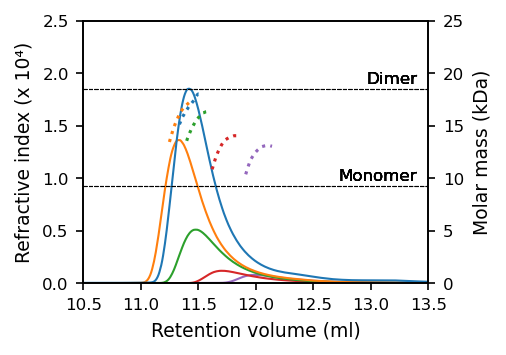

In [4]:
fig, ax1, ax2 = create_fig(csv_wt_500ugml, c='tab:purple')
fig, ax1, ax2 = create_fig(csv_wt_750ugml, fig=fig, ax1=ax1, ax2=ax2, c='tab:red')
fig, ax1, ax2 = create_fig(csv_wt_2000ugml, fig=fig, ax1=ax1, ax2=ax2, c='tab:green')
fig, ax1, ax2 = create_fig(csv_wt_5000ugml, fig=fig, ax1=ax1, ax2=ax2, c='tab:orange')
fig, ax1, ax2 = create_fig(csv_wt_10000ugml, fig=fig, ax1=ax1, ax2=ax2, c='tab:blue')
ax1.set_ylim(top=2.5)
fig.set_size_inches(3.5, 2.5)
fig.subplots_adjust(left=0.2, bottom=0.2, top=0.9)
fig.savefig('Figs/wt_titration.png', dpi=600, transparent=True)

### Plot: L109R

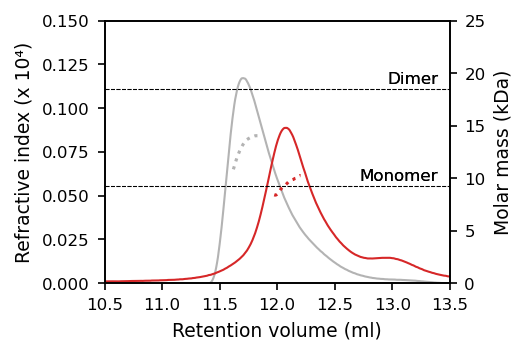

In [9]:
fig, ax1, ax2 = create_fig(csv_wt_750ugml,  c='0.7')
fig, ax1, ax2 = create_fig(csv_L109R, fig=fig, ax1=ax1, ax2=ax2, ylim1=[0, 0.1], c='tab:red')
fig.set_size_inches(3.8,2.8)
ax1.set_ylim(top=0.15)
fig.set_size_inches(3.5, 2.5)
fig.subplots_adjust(left=0.2, bottom=0.2, top=0.9)
fig.savefig('Figs/L109R.png', dpi=600, transparent=True)